# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

Make an informed selection of 4 scenarios. Motivate carefully your selection procedure. 


In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter,
                           MultiprocessingEvaluator, Policy, Scenario)

from dike_model_function import DikeNetwork  # @UnresolvedImport


def sum_over(*args):
    return sum(args)

from ema_workbench import (Model, )

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time

from problem_formulation import get_model_for_problem_formulation


ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [5]:
uncertainties = dike_model.uncertainties
levers = dike_model.levers 

import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

In [6]:
#running the model through EMA workbench
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments, SequentialEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=10, policies = 3)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 3 policies * 1 model(s) = 30 experiments
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] 21 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 27 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


or import already available experiments

In [9]:
#import pandas as pd
##from ema_workbench import load_results
#
##experiments, outcomes = load_results('mordm_42.tar.gz')
##y = outcomes['utility'] < 0.35
#experiments = pd.read_csv('outcomes/Experiments_from_Exploration_1000scenarios_pf5.csv')
#outcomes = pd.read_csv('outcomes/Outcomes_from_Exploration_1000scenarios_pf5.csv')
#outcomes

,Unnamed: 0,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,0,2.864968e+06,0,0.002551,1.224951e+07,0,0.014384,3.227622e+08,0,0.674369,...,0,0.674369,3.399553e+07,0,0.016105,0.000000e+00,0,0.000000,0.0,0.0
1,1,1.552122e+08,0,0.103901,7.038358e+07,0,0.061568,0.000000e+00,0,0.000000,...,0,0.000000,9.712557e+06,0,0.003300,0.000000e+00,0,0.000000,0.0,0.0
2,2,1.019891e+09,0,0.649281,0.000000e+00,0,0.000000,4.216252e+07,0,0.071390,...,0,0.071390,4.540444e+06,0,0.002453,0.000000e+00,0,0.000000,0.0,0.0
3,3,0.000000e+00,0,0.000000,2.028020e+06,0,0.001955,4.012571e+08,0,0.664711,...,0,0.664711,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
4,4,1.008722e+09,0,0.640347,1.456189e+08,0,0.123812,0.000000e+00,0,0.000000,...,0,0.000000,2.105130e+07,0,0.009470,0.000000e+00,0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,6.576008e+08,0,0.638806,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,...,0,0.000000,3.261335e+05,0,0.000130,1.973620e+08,0,0.126116,0.0,0.0
996,996,3.955526e+07,0,0.034010,4.903057e+07,0,0.054504,0.000000e+00,0,0.000000,...,0,0.000000,4.211407e+07,0,0.019926,0.000000e+00,0,0.000000,0.0,0.0
997,997,2.350814e+06,0,0.002553,1.004554e+07,0,0.014391,4.750060e+08,0,1.181821,...,0,1.181821,0.000000e+00,0,0.000000,5.353897e+06,0,0.007095,0.0,0.0
998,998,6.585741e+07,0,0.034932,2.593805e+08,0,0.170337,0.000000e+00,0,0.000000,...,0,0.000000,5.145870e+07,0,0.019190,0.000000e+00,0,0.000000,0.0,0.0


there are many ways in which you can make an informed selection. Examples include
* --> pick best and worst for each outcome of interest
* maximize diversity following Eker & Kwakkel
* visually selected them

## best case, worst case

In [10]:
outcomes_DF = pd.DataFrame(outcomes)

outcomes_DF

,A.4_Expected Annual Damage 0,A.4_Dike Investment Costs 0,A.4_Expected Number of Deaths 0,A.5_Expected Annual Damage 0,A.5_Dike Investment Costs 0,A.5_Expected Number of Deaths 0,RfR Total Costs 0,Expected Evacuation Costs 0,A.4_Expected Annual Damage 1,A.4_Dike Investment Costs 1,...,RfR Total Costs 1,Expected Evacuation Costs 1,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,2.635183e+05,8.453408e+06,0.000026,0.000000e+00,3.667668e+07,0.000000,423600000.0,26.088867,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000
1,0.000000e+00,8.453408e+06,0.000000,0.000000e+00,3.667668e+07,0.000000,423600000.0,0.000000,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000
2,6.521397e+05,8.453408e+06,0.000047,2.254451e+07,3.667668e+07,0.002951,423600000.0,1832.726335,0.0,2.254621e+07,...,408000000.0,1816.101036,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000
3,0.000000e+00,8.453408e+06,0.000000,0.000000e+00,3.667668e+07,0.000000,423600000.0,0.000000,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000
4,0.000000e+00,8.453408e+06,0.000000,0.000000e+00,3.667668e+07,0.000000,423600000.0,424.311876,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000
5,0.000000e+00,8.453408e+06,0.000000,0.000000e+00,3.667668e+07,0.000000,423600000.0,0.000000,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000
6,2.587882e+06,8.453408e+06,0.000146,0.000000e+00,3.667668e+07,0.000000,423600000.0,183.504253,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000
7,0.000000e+00,8.453408e+06,0.000000,0.000000e+00,3.667668e+07,0.000000,423600000.0,0.000000,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000
8,0.000000e+00,8.453408e+06,0.000000,0.000000e+00,3.667668e+07,0.000000,423600000.0,0.000000,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000
9,0.000000e+00,8.453408e+06,0.000000,0.000000e+00,3.667668e+07,0.000000,423600000.0,0.000000,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.000000


In [16]:
y = outcomes['A.4_Expected Number of Deaths 0'] > 0.00001 # too many, just for the sake of demonstration

data = pd.DataFrame({k:v[y] for k,v in outcomes.items()})
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/analysis/parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


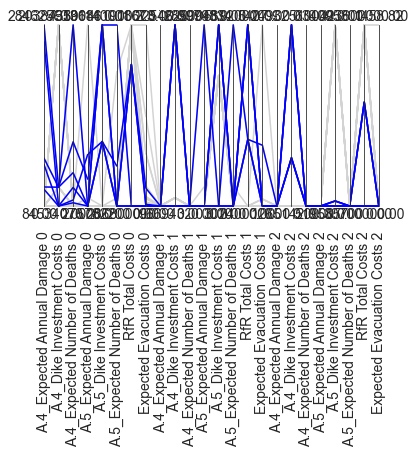

In [18]:
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt

limits = parcoords.get_limits(all_data)

axes = parcoords.ParallelAxes(limits)

axes.plot(all_data, color='lightgrey')
axes.plot(data, color='blue')
plt.show()

In [28]:
data

,A.4_Expected Annual Damage 0,A.4_Dike Investment Costs 0,A.4_Expected Number of Deaths 0,A.5_Expected Annual Damage 0,A.5_Dike Investment Costs 0,A.5_Expected Number of Deaths 0,RfR Total Costs 0,Expected Evacuation Costs 0,A.4_Expected Annual Damage 1,A.4_Dike Investment Costs 1,...,RfR Total Costs 1,Expected Evacuation Costs 1,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,2.635183e+05,8.453408e+06,0.000026,0.000000e+00,3.667668e+07,0.000000,423600000.0,26.088867,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.0
1,6.521397e+05,8.453408e+06,0.000047,2.254451e+07,3.667668e+07,0.002951,423600000.0,1832.726335,0.0,2.254621e+07,...,408000000.0,1816.101036,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.0
2,2.587882e+06,8.453408e+06,0.000146,0.000000e+00,3.667668e+07,0.000000,423600000.0,183.504253,0.0,2.254621e+07,...,408000000.0,0.000000,0.0,2.493252e+07,0.0,0.0,5.227813e+07,0.0,256100000.0,0.0
3,2.995375e+05,9.695195e+06,0.000261,0.000000e+00,5.311400e+07,0.000000,286800000.0,0.000000,0.0,9.669433e+06,...,589200000.0,0.000000,0.0,1.592391e+07,0.0,0.0,5.195858e+07,0.0,30700000.0,0.0
4,7.513826e+05,9.695195e+06,0.000502,1.177470e+07,5.311400e+07,0.013345,286800000.0,0.000000,0.0,9.669433e+06,...,589200000.0,0.000000,0.0,1.592391e+07,0.0,0.0,5.195858e+07,0.0,30700000.0,0.0
5,2.846257e+06,9.695195e+06,0.001417,0.000000e+00,5.311400e+07,0.000000,286800000.0,0.000000,0.0,9.669433e+06,...,589200000.0,0.000000,0.0,1.592391e+07,0.0,0.0,5.195858e+07,0.0,30700000.0,0.0


In [19]:
print(data.idxmax())

A.4_Expected Annual Damage 0       5
A.4_Dike Investment Costs 0        3
A.4_Expected Number of Deaths 0    5
A.5_Expected Annual Damage 0       1
A.5_Dike Investment Costs 0        3
A.5_Expected Number of Deaths 0    4
RfR Total Costs 0                  0
Expected Evacuation Costs 0        1
A.4_Expected Annual Damage 1       0
A.4_Dike Investment Costs 1        0
A.4_Expected Number of Deaths 1    0
A.5_Expected Annual Damage 1       1
A.5_Dike Investment Costs 1        3
A.5_Expected Number of Deaths 1    1
RfR Total Costs 1                  3
Expected Evacuation Costs 1        1
A.4_Expected Annual Damage 2       0
A.4_Dike Investment Costs 2        0
A.4_Expected Number of Deaths 2    0
A.5_Expected Annual Damage 2       0
A.5_Dike Investment Costs 2        0
A.5_Expected Number of Deaths 2    0
RfR Total Costs 2                  0
Expected Evacuation Costs 2        0
dtype: int64


In [21]:
#print(data.idxmin())

we now have 8 indices, so we could optimize for each of these 8 scenarios. This might be a bit overkil, so you could also take a worst case stance. In that case,  you would use the max for max_P and the minimum for the others.

Hence for us it's max for all!

In [29]:
# also all we need are the uncertainty columns
selected = experiments.loc[[0,1,3,4,5], experiments.columns[0:-3]]
selected

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat
0,123.0,34.087826,1.5,0.618451,335.508561,10,0.255563,194.045813,1,0.634266,...,8.0,3.0,6.0,3.0,10.0,8.0,5.0,0.0,7.0,3.0
1,59.0,311.020237,1.5,0.512585,38.129213,10,0.722786,272.033792,10,0.489451,...,8.0,3.0,6.0,3.0,10.0,8.0,5.0,0.0,7.0,3.0
3,6.0,146.516994,1.5,0.903980,265.751825,1.5,0.331094,251.374618,1,0.713819,...,8.0,3.0,6.0,3.0,10.0,8.0,5.0,0.0,7.0,3.0
4,28.0,241.371668,1.5,0.494351,162.831105,1.5,0.015359,112.509596,1.5,0.077538,...,8.0,3.0,6.0,3.0,10.0,8.0,5.0,0.0,7.0,3.0
5,83.0,340.405679,1,0.169594,287.178842,10,0.954086,324.152796,1,0.888637,...,8.0,3.0,6.0,3.0,10.0,8.0,5.0,0.0,7.0,3.0


In [31]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


Since we have to do the same thing for each scenario, it is convenient to wrap this in a function we can call with the scenario under which we want to optimize. 

In [60]:
from ema_workbench import MultiprocessingEvaluator, ema_logging, SequentialEvaluator
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

ema_logging.log_to_stderr(ema_logging.INFO)

def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with SequentialEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence


results = []
for scenario in scenarios:
    convergence_metrics = [#HyperVolume(minimum=[0,0,0,0], maximum=[3, 2,1.01,1.01]),
                           EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes) #0.1
    
    results.append(optimize(scenario, 1e2, dike_model, convergence_metrics, epsilons)) #1e4 --> list index out of range



[MainProcess/INFO] generation 0: 0/100 nfe
[MainProcess/INFO] optimization completed, found 96 solutions
[MainProcess/INFO] generation 0: 0/100 nfe
[MainProcess/INFO] optimization completed, found 98 solutions
[MainProcess/INFO] generation 0: 0/100 nfe
[MainProcess/INFO] optimization completed, found 82 solutions
[MainProcess/INFO] generation 0: 0/100 nfe
[MainProcess/INFO] optimization completed, found 87 solutions
[MainProcess/INFO] generation 0: 0/100 nfe
[MainProcess/INFO] optimization completed, found 92 solutions


In [68]:
results[0]

(    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
 0         1        1        0        0        0        1        1        1   
 1         0        1        1        0        0        1        0        1   
 2         1        1        0        1        1        0        1        0   
 3         1        1        1        1        0        1        1        1   
 4         0        1        1        1        0        0        1        0   
 ..      ...      ...      ...      ...      ...      ...      ...      ...   
 91        0        0        0        0        1        0        0        0   
 92        0        0        0        0        1        0        0        1   
 93        0        0        0        0        0        0        0        0   
 94        0        0        0        1        1        1        1        1   
 95        0        0        0        0        0        0        0        0   
 
     2_RfR 2  3_RfR 0  ...  RfR Total Costs 1  Exp

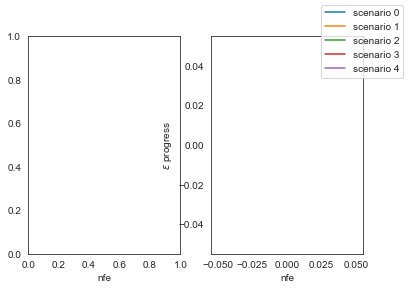

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
for i, (_, convergence) in enumerate(results):
    #ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

#ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

## From here on kwakkel's solution

below is a quick visualization of the trade-offs found for each scenario. It does reveal how optimizing under differen scenarios reveals different trade-offs

Note that this is in a way a misleading figure because the scenario under which each of these sets of solutions is being evaluated is not the same.

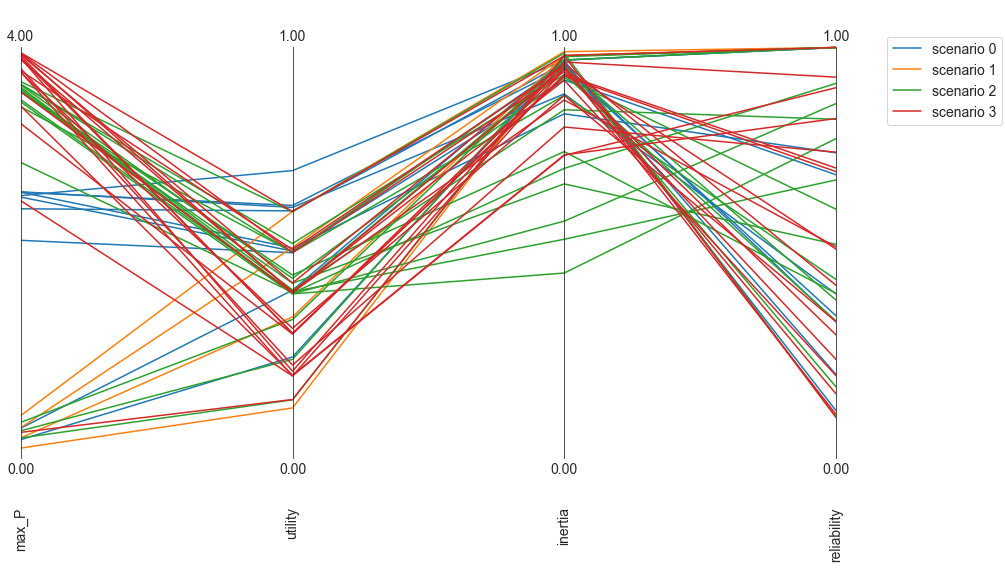

In [50]:
from ema_workbench.analysis import parcoords

colors = iter(sns.color_palette())

data = results[0][0].iloc[:, 5::]
limits = parcoords.get_limits(data)

limits.loc[0, ['inertia', 'reliability']] = 1
limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()


## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [58]:
from ema_workbench import Policy

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:5]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

In [60]:
with MultiprocessingEvaluator(model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 46 policies * 1 model(s) = 46000 experiments
[MainProcess/INFO] 4600 cases completed
[MainProcess/INFO] 9200 cases completed
[MainProcess/INFO] 13800 cases completed
[MainProcess/INFO] 18400 cases completed
[MainProcess/INFO] 23000 cases completed
[MainProcess/INFO] 27600 cases completed
[MainProcess/INFO] 32200 cases completed
[MainProcess/INFO] 36800 cases completed
[MainProcess/INFO] 41400 cases completed
[MainProcess/INFO] 46000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [91]:
experiments, outcomes = reeevaluation_results

thresholds = {'utility':0.75, 'inertia':0.99, 'reliability':0.8}

overall_scores = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    scores = {}
    for k, v in outcomes.items():
        try:
            n = np.sum(v[logical]>=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

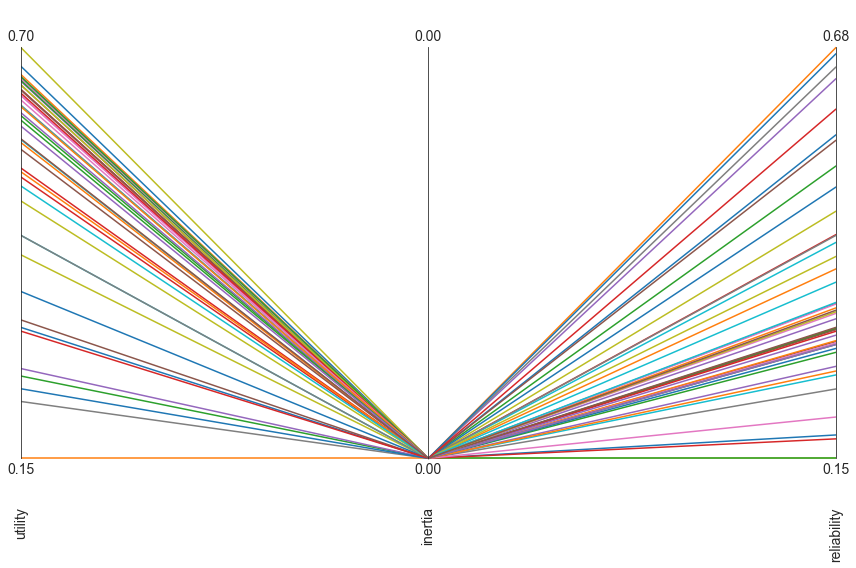

In [92]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

There are many ways of coding the regret calculating. Here I choose to use dataframes. I basically wanted to use the groupby method on a dataframe with the regret for each policy in each scenario. Reasoning backward from there, I arrived at the code shown below. 

There are probably ways of coding this even more efficient. My guess is that a groupby over the scenarios would help in calculating the best performance in each scnenario, avoiding one more explicit loop. I leave this as an exercise for you.

In [120]:
overall_scores = {}
regret = []
for scenario in experiments.scenario.unique():
    logical = experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = experiments[experiments.scenario==scenario]
        
    best = temp_results.max()
    best['max_P'] = temp_results.max_P.min()
    scenario_regret = a - best
    scenario_regret['policy'] = temp_experiments.policy.values    
    regret.append(scenario_regret)


In [121]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max()

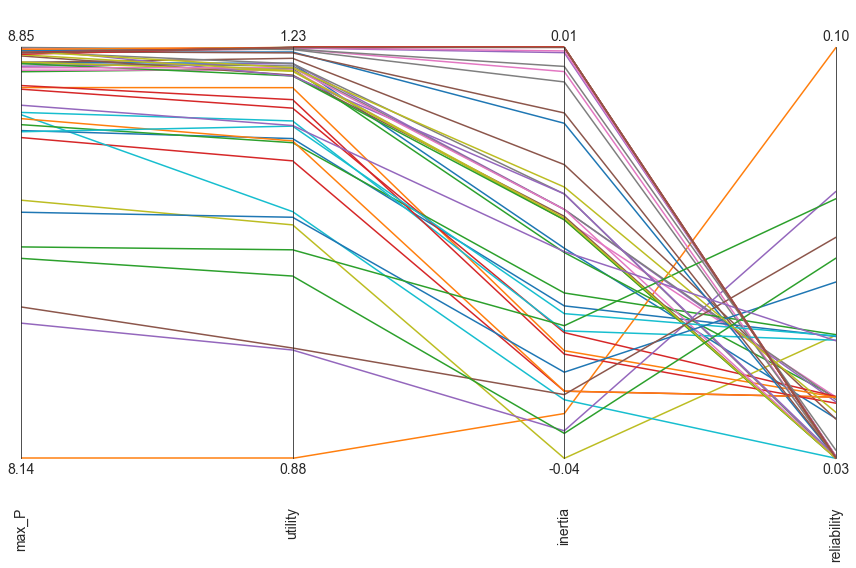

In [123]:
limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)
paraxes.plot(maxregret)
plt.show()